# Object-based filtering of pixel classifications <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment


## Background

Geographic Object-Based Image Analysis (GEOBIA), aims to group pixels together into meaningful image-objects. There are two advantages to a GEOBIA workflow: one, we can reduce the 'salt and pepper' effect typical of classifying pixels; and two, we can increase the computational efficiency of our workflow by grouping pixels into fewer, larger, but more meaningful objects. A review of the emerging trends in GEOBIA can be found in [Chen et al. (2017)](https://www.tandfonline.com/doi/abs/10.1080/15481603.2018.1426092).

## Description

In this notebook, we take the pixel-based classifications generated in the `4_Classify_satellite_data.ipynb` notebook, and filter the classifications by image-objects. To do this, we first need to conduct image segmentation using the function `rsgislib.segmentation.runShepherdSegmentation`. This image segmentation algorithm is fast and scalable.  The image segmentation is conducted on the `NDVI` layer output in the previous notebook.
To filter the pixel observations, we assign to each segment the majority (mode) pixel classification using the `scipy.ndimage.measurements import _stats` module. 

1. Convert the NDVI layer to a `.kea` file format (a requirement for the Remote Sensing and GIS Software Library, RSGISLib)
2. Run the image segmentation
3. Calculate the **mode** statistic for each segment
4. Write the new object-based classification to disk as a COG
5. An advanced section that demonstrates running a tiled, parallel image segmentation (useful if segmenting a very large GeoTIFF)

***
## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load Packages

In [1]:
import os
import sys
import gdal
import shutil
import xarray as xr
import numpy as np
import subprocess as sp
import matplotlib.pyplot as plt
from odc.io.cgroups import get_cpu_quota
from datacube.utils.cog import write_cog
from rsgislib.segmentation import segutils
from scipy.ndimage.measurements import _stats

sys.path.append('../../Scripts')
from dea_classificationtools import HiddenPrints

import warnings
warnings.filterwarnings("ignore")

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/env/lib/python3.6/site-packages/datacube/storage/masking.py:8: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


## Analysis Parameters

* `pred_tif`: The path and name of the prediction GeoTIFF output in the previous notebook.
* `tif_to_seg`: The geotiff to use as an input to the image segmentation, in the default example this was an NDVI layer output in the last notebook.
* `min_seg_size`: An integer which specifies the minimum number of pixels within a segment; segments with fewer than then minimum number of pixels are merged with adjacent segments. 
* `numClusters`: An integer which specifies the number of clusters within the KMeans clustering. A good default is 60.
* `results`: A folder location to store the classified GeoTIFFs.

In [2]:
pred_tif = 'results/prediction.tif'

tif_to_seg = 'results/NDVI.tif'

min_seg_size = 100  # in number of pixels

numClusters = 60  # number of k-means clusters

results = 'results/'

## Generate an object-based classification

### Convert to `.kea` format

In [3]:
# Inputs to image seg
kea_file = tif_to_seg[:-4] + '.kea'
segmented_kea_file = tif_to_seg[:-4] + '_segmented.kea'

# Convert tiff to kea
gdal.Translate(destName=kea_file,
               srcDS=tif_to_seg,
               format='KEA',
               outputSRS='EPSG:6933')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fd0f8de2570> >

### Run image segmentation

In [4]:
%%time

# Store temp files somewhere
tmp = 'tmp/'
if not os.path.exists(tmp):
    os.mkdir(tmp)

# Run image seg
with HiddenPrints():
    segutils.runShepherdSegmentation(inputImg=kea_file,
                                     outputClumps=segmented_kea_file,
                                     tmpath=tmp,
                                     numClusters=numClusters,
                                     minPxls=min_seg_size)

CPU times: user 51.7 s, sys: 241 ms, total: 52 s
Wall time: 52 s


### Open segments and pixel-based predictions

In [5]:
segments = xr.open_rasterio(segmented_kea_file).squeeze().values
pred = xr.open_rasterio(pred_tif).squeeze().drop_vars('band')

### Calculate mode

Within each segment, the majority classification is calculated and assigned to that segment.

In [6]:
count, _sum = _stats(pred, labels=segments, index=segments)
mode = _sum > (count / 2)
mode = xr.DataArray(mode, coords=pred.coords, dims=pred.dims,
                    attrs=pred.attrs).astype(np.int16)

### Clean up intermediate files

In [7]:
shutil.rmtree(tmp)
os.remove(kea_file)
os.remove(segmented_kea_file)

### Write result to disk

In [8]:
write_cog(mode, results + 'prediction_object_.tif', overwrite=True)

PosixPath('results/prediction_object_.tif')

### Plot result

Below we plot the the pixel-based classification alongside the newly created object-based classification. You can see the 'salt and pepper' effect of individual pixels being classified as crop has been removed in the object based classification, resulting in a 'cleaner' classification. 

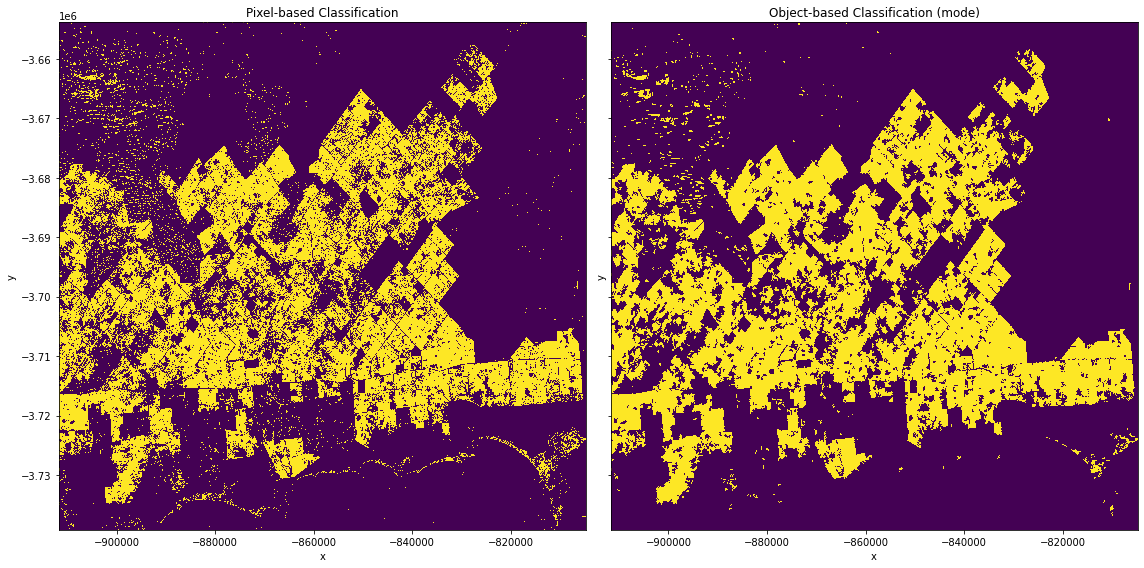

In [9]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(16, 8))
pred.plot(ax=axes[0], add_colorbar=False)
mode.plot(ax=axes[1], add_colorbar=False)
axes[0].set_title('Pixel-based Classification')
axes[1].set_title('Object-based Classification (mode)')
plt.tight_layout()

***
## Optional: Tiled, parallel image segmentation

Image segmentation at large scales can be both time and memory intensive. The module `dea_tools.segmentation.performTiledSegmentation` builds upon the image segmentation algorithm developed by Shepherd et al. (2019) (implemented in the package RSGISLib) to run image segmentation across multiple CPUs. A full description of their approach can be found in _Clewey et al. (2014) A Python-Based Open Source System for Geographic Object-Based Image Analysis (GEOBIA) Utilizing Raster Attribute Tables_. The code below demonstrates how to use the `dea_tools.segmentation.performTiledSegmentation` module to conduct a tiled, parallel image segmentation. 

The tiling approach is based on the bounding coordinates of the GeoTIFF. If a GeoTIFF is irregularly shaped such that a tile(s) contains none of the input GeoTIFF, then the segmentation will fail. If this occurs, check the `<>S1Tiles.shp` file output during stage 1 of the algorithm. Overlay this file on top of your input GeoTIFF to check if there are empty tiles. At the moment, the only solution is to change the extent of the GeoTIFF to be more regularly shaped. The `validDataTileFraction` variable will handle tiles that contain a small fraction of the input GeoTIFF, tiles containing less than the specified fraction are merged with a neighbouring tile. The image below shows an example of the tiling approach with merged tiles:

<img align="center" src="../../Supplementary_data/Scalable_machine_learning/tilingApproach.png" width="35%">

Below, we will conduct the same analysis as we did in the first example above, but this time the image segmentation will be conducted using the `dea_tools.segmentation.performTiledSegmentation()` function. For the default example, this will be slower than the serial version, however, when conducting image segmentation over very large GeoTIFFs, this option will be preferred.

In [10]:
# Import the parallel segementation module
sys.path.append('../../Scripts')
from dea_segmentation import performTiledSegmentation

## Analysis Parameters

* `validDataTileFraction`: The fraction of a tile that should contain valid data. Below this threshold, a tile will be merged with its neighbour. e.g. `0.3`
* `tile_width, tile_height`: The tile size parameters in number of pixels

In [11]:
# New parameters to add
validDataTileFraction = 0.2
tile_width, tile_height = 1000, 1000

# Previous parameters we added above, reposting here
pred_tif = 'results/prediction.tif'
tif_to_seg = 'results/NDVI.tif'
min_seg_size = 100
results = 'results/'

### Automatically find the number of CPUs

In [12]:
ncpus = round(get_cpu_quota())
print('ncpus = ' + str(ncpus))

ncpus = 7


## Tiled, parallel image segmentation

### Convert `.tif` to `.kea`

In [13]:
# Store temp files somewhere
tmp = 'tmp/'
if not os.path.exists(tmp):
    os.mkdir(tmp)

# Inputs to image seg
kea_file = tif_to_seg[:-4] + '.kea'
segmented_kea_file = tif_to_seg[:-4] + '_segmented.kea'

# Convert tiff to kea
gdal.Translate(destName=kea_file,
               srcDS=tif_to_seg,
               format='KEA',
               outputSRS='EPSG:6933')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fd0c788de10> >

### Run the parallel, tiled segmentation

This will take a couple of minutes to run.

In [14]:
# Run the segmentation
with HiddenPrints():
    performTiledSegmentation(kea_file,
                             segmented_kea_file,
                             tmpDIR=tmp,
                             numClusters=numClusters,
                             validDataThreshold=validDataTileFraction,
                             tileWidth=tile_width,
                             tileHeight=tile_height,
                             minPxls=min_seg_size,
                             ncpus=ncpus)

# Remove tmp folder
shutil.rmtree(tmp)

### Open segments and pixel-based predictions

In [15]:
segments = xr.open_rasterio(segmented_kea_file).squeeze().values
pred = xr.open_rasterio(pred_tif).squeeze().drop_vars('band')

### Calculate mode

In [16]:
count, _sum = _stats(pred, labels=segments, index=segments)
mode = _sum > (count / 2)
mode = xr.DataArray(mode, coords=pred.coords, dims=pred.dims,
                    attrs=pred.attrs).astype(np.int16)

### Clean up intermediate files

In [17]:
os.remove(kea_file)
os.remove(segmented_kea_file)

### Plot the result

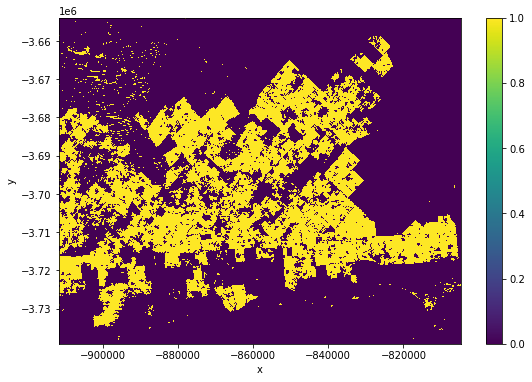

In [18]:
mode.plot(size=6);

## Recommended next steps

This is the last notebook in the `Scalable Machine Learning on the ODC` workflow! To revist any of the other notebooks, use the links below.

1. [Extracting training data from the ODC](1_Extract_training_data.ipynb) 
2. [Inspecting training data](2_Inspect_training_data.ipynb)
3. [Evaluate, optimize, and fit a classifier](3_Evaluate_optimize_fit_classifier.ipynb)
4. [Classifying satellite data](4_Classify_satellite_data.ipynb)
5. **Object-based filtering of pixel classifications (this notebook)**



***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** March 2021


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)